# Predicting which banking customers will leave the bank in the following six months
## XGBoost and Shap


Nuno António - Rev. 1.00 - 2020-2021

### Dataset description


- **RowNumber**: row number.
- **CustomerId**: internal ID of the customer.
- **Surname**: customer's surname.
- **CreditScore**: customers's credit score/rating. The higher the score the better the customer.
- **Geography**: customer’s location.
- **Gender**: customer's gender.
- **Age**: customer's age. A known business fact is that older customers are less likely to leave the bank than younger ones.
- **Tenure**: number of years since the customer has been a client of the bank. Usually, older clients are more loyal and less likely to leave a bank.
- **Balance**: sum of the balances of all accounts of the customer.
- **NumOfProducts**: number of products that a customer has purchased through the bank.
- **HasCrCard**: binary variable indicating whether or not a customer has a credit card.
- **IsActiveMember**: binary variable indicating whether or not a customer is active in having iterations with the bank.
- **EstimatedSalary**: customer's estimated salary.
- **Exited**: binary variable indicating whether or not the customer left the bank (target variable).


More information on the dataset available at https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

### Initial setup and modules/packages loading

In [231]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import collections
import math
import time
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import xgboost
import shap

In [192]:
# Init Javascript for shap visualizations
shap.initjs()

### Data understanding

In [193]:
# Load data 
ds = pd.read_csv('Bank_Churn_Modelling.csv')
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [194]:
# Display top 10 rows
ds.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [195]:
# Summary statistics for all variables
summary=ds.describe(include='all')
summary=summary.transpose()
summary.head(len(summary))

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
RowNumber,10000,NaN,NaN,NaN,5000.5,2886.9,1,2500.75,5000.5,7500.25,10000
CustomerId,10000,NaN,NaN,NaN,1.56909e+07,71936.2,1.55657e+07,1.56285e+07,1.56907e+07,1.57532e+07,1.58157e+07
Surname,10000,2932,Smith,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CreditScore,10000,NaN,NaN,NaN,650.529,96.6533,350,584,652,718,850
Geography,10000,3,France,5014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,10000,2,Male,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,10000,NaN,NaN,NaN,38.9218,10.4878,18,32,37,44,92
Tenure,10000,NaN,NaN,NaN,5.0128,2.89217,0,3,5,7,10
Balance,10000,NaN,NaN,NaN,76485.9,62397.4,0,0,97198.5,127644,250898
NumOfProducts,10000,NaN,NaN,NaN,1.5302,0.581654,1,1,1,2,4


In [196]:
# Check counts of categorical variables
cols = ['Geography', 'Gender']
ds[cols].apply(pd.Series.value_counts)

,Geography,Gender
Female,NaN,4543.0
France,5014.0,NaN
Germany,2509.0,NaN
Male,NaN,5457.0
Spain,2477.0,NaN


In [197]:
# Convert CustomerId to categorical and chek for duplicates
ds['CustomerId'] = ds['CustomerId'].astype('category')
ds.CustomerId.describe()

count        10000
unique       10000
top       15815690
freq             1
Name: CustomerId, dtype: int64

In [198]:
# Check missing values
print(ds.isnull().sum())

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


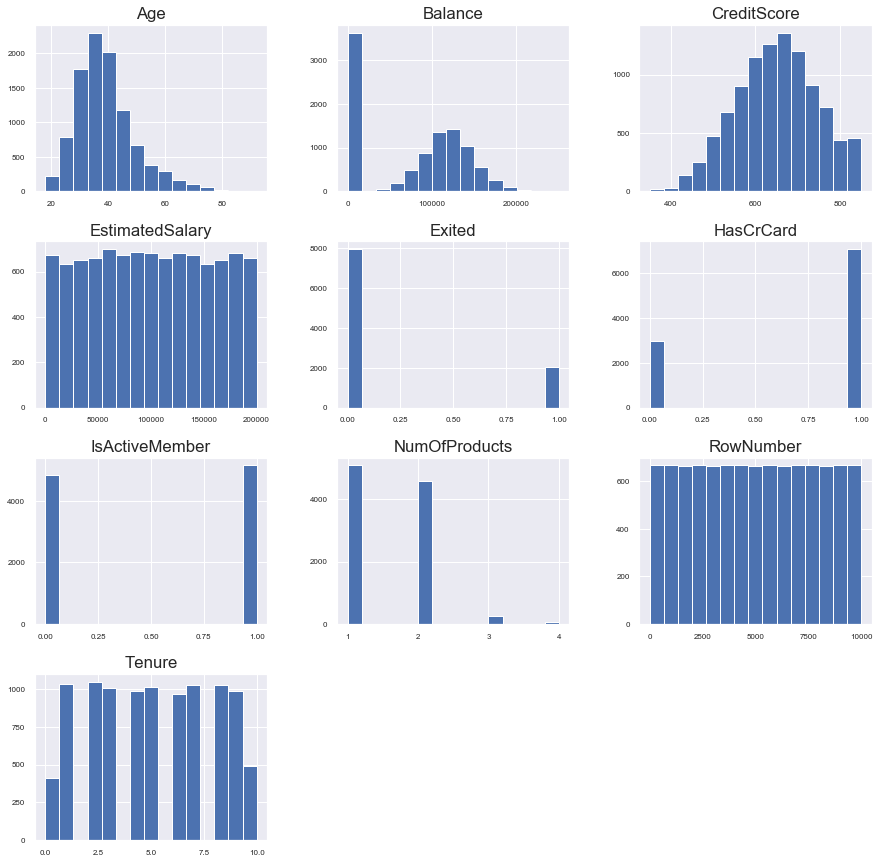

In [199]:
# Do histograms on all numeric variables
numerical=ds.select_dtypes(include=[np.number]).columns.tolist()
ds[numerical].hist(bins=15, figsize=(15, 15), layout=(4, 3), xlabelsize=8, ylabelsize=8);

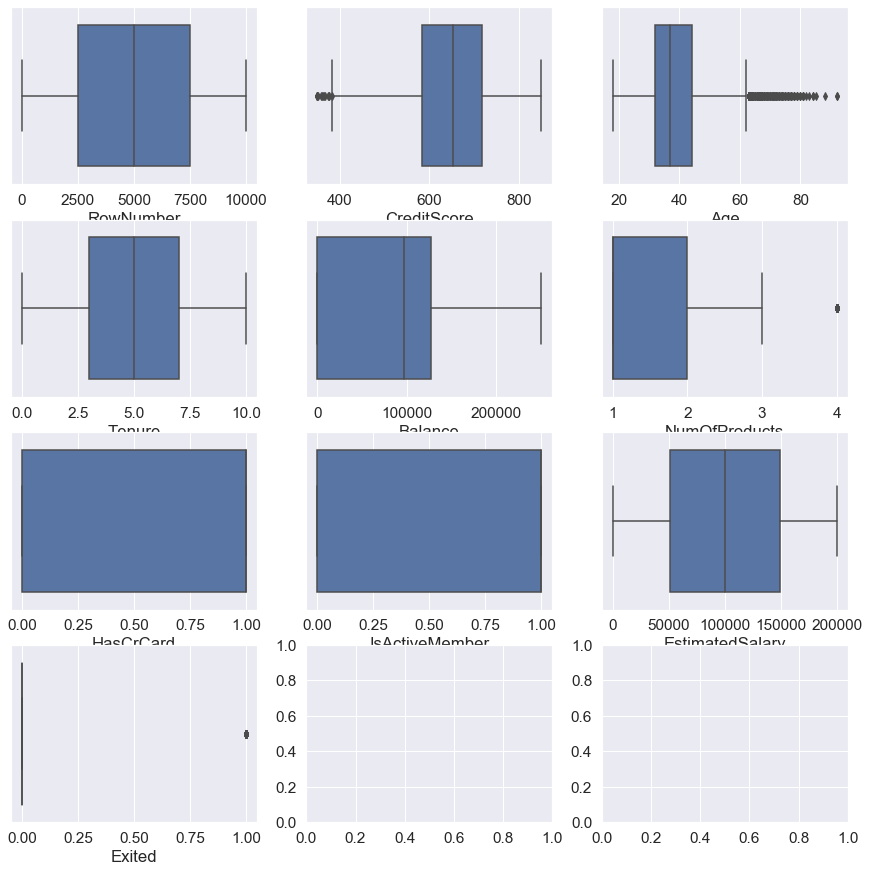

In [200]:
# Do boxplots on all numeric variables
fig, ax = plt.subplots(4, 3, figsize=(15, 15))
for var, subplot in zip(ds[numerical], ax.flatten()):
    sns.boxplot(ds[var], ax=subplot)
    

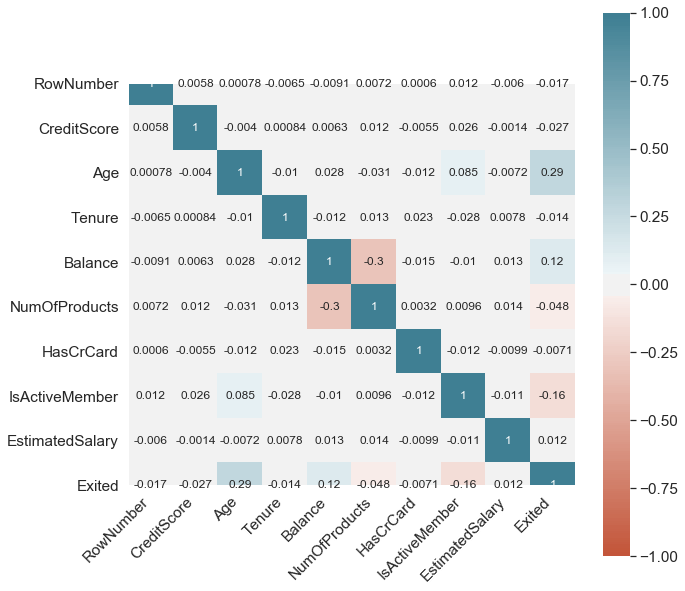

In [201]:
# Plot correlation heatmap of all numeric variables
corr = ds[numerical].corr()
plt.figure(figsize=(10, 10))
sns.set(font_scale=1.4)
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True, annot_kws={"size": 12}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### Data preparation

In [202]:
# Create a modeling dataset from the original dataset
X = ds.copy(deep=True)

In [203]:
# Remove columns that should not be used
cols = ['RowNumber', 'CustomerId', 'Surname']
X.drop(columns=cols, inplace=True)

In [204]:
# Encode categorical variables to dummy variables
cols = ['Geography', 'Gender']
ce_one_hot = ce.OneHotEncoder(cols = cols, use_cat_names=True)
X = ce_one_hot.fit_transform(X)

### Modeling - XGBoost

In [205]:
# Create the Target
y = X['Exited']

In [206]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=123)

In [207]:
# Remove the Target from the training
X_train = X_train.drop(['Exited'],1)
X_test = X_test.drop(['Exited'],1)

Counter({0: 5972, 1: 1528})
0    0.796267
1    0.203733
Name: Exited, dtype: float64


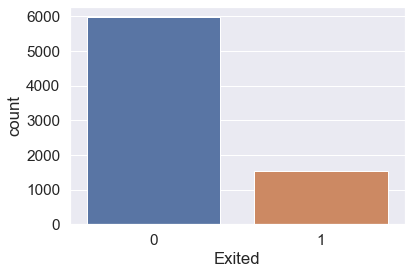

In [208]:
# Display target balance in the training dataset
print(collections.Counter(y_train))
sns.countplot(x="Exited", data=pd.DataFrame(data={'Exited':y_train}))
print(y_train.value_counts(normalize=True))

In [209]:
# Create object and train the model
classModel = xgboost.XGBClassifier(n_estimators=300,
                           subsample=0.9,
                           colsample_bytree=0.9,
                           max_depth=3,
                           eval_metric='error',
                           verbose=True,
                           seed=123,
                           scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1]
                           )
classModel.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=300, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic',
              random_state=123, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=3.9083769633507854, seed=123, subsample=0.9,
              tree_method=None, validate_parameters=False, verbose=True,
              verbosity=None)

### Evaluation - XGBoost

In [210]:
# predict y for X_train and X_test
y_pred_train = classModel.predict(X_train) 
y_pred_test = classModel.predict(X_test) 

In [211]:
# Function to create dataframe with metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest):
  measures_list = ['ACCURACY','PRECISION', 'RECALL']
  train_results = [metricsObj.accuracy_score(yTrain, yPredTrain),
                metricsObj.precision_score(yTrain, yPredTrain),
                metricsObj.recall_score(yTrain, yPredTrain)]
  test_results = [metricsObj.accuracy_score(yTest, yPredTest),
               metricsObj.precision_score(yTest, yPredTest),
               metricsObj.recall_score(yTest, yPredTest)]
  resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results})
  return(resultsDF)

In [212]:
# Function to plot confusion matrix - Adapted from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    ax = sns.heatmap(cf,annot=box_labels, fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)
    bottom, top = ax.get_ylim() # These two lines were added due to bug on current Seaborn version
    ax.set_ylim(bottom + 0.5, top - 0.5) #

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

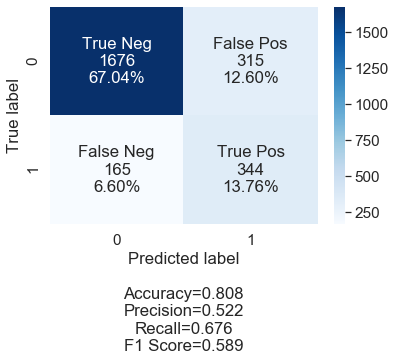

In [213]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_pred_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [214]:
resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, y_test, y_pred_test)
resultsDF

,Measure,Train,Test
0,ACCURACY,0.903067,0.808000
1,PRECISION,0.698562,0.522003
2,RECALL,0.922120,0.675835


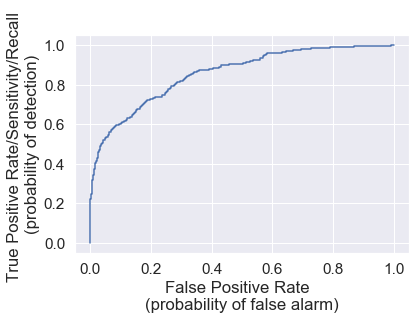

AUC:0.856
Optimal threshold:0.434


In [215]:
# ROC curve
probs = classModel.predict_proba(X_test)
FP,TP,thresholds = metrics.roc_curve(y_test,probs[:,1])
plt.plot(FP,TP,label="ROC")
plt.xlabel("False Positive Rate  \n(probability of false alarm)")
plt.ylabel("True Positive Rate/Sensitivity/Recall \n(probability of detection)")
cutoff=np.argmax(np.abs(TP-FP)) 
optimal_threshold = thresholds[cutoff]
plt.show()
print("AUC:{0:.3f}".format(metrics.auc(FP, TP)))
print("Optimal threshold:{0:.3f}".format(optimal_threshold))

<font color='blue'>Q1: Are these results good?</font><br>

### Feature predictive importance from XGBoost
For more information: https://xgboost.readthedocs.io/en/latest/python/python_api.html

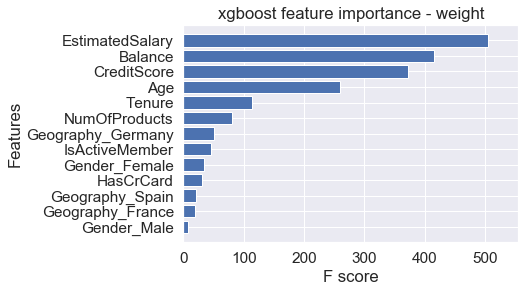

In [227]:
# Weight - The number of times a feature is used to split the data across all trees
xgboost.plot_importance(classModel, importance_type="weight", show_values=False, height=0.8)
plt.title("xgboost feature importance - weight")
plt.show()

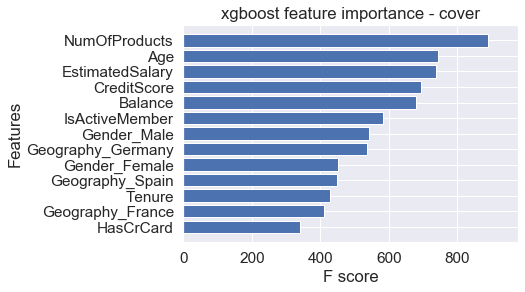

In [228]:
# Cover - The number of times a feature is used to split the data across all trees weighted by the number of training instances that go thru the splits
xgboost.plot_importance(classModel, importance_type="cover", show_values=False, height=0.8)
plt.title("xgboost feature importance - cover")
plt.show()

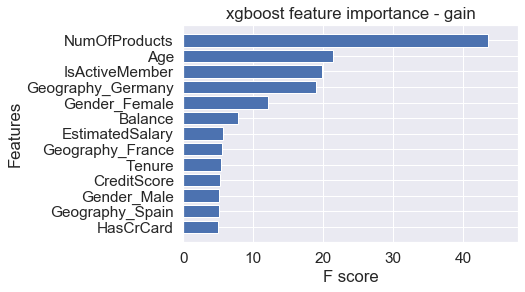

In [229]:
# Gain - The average training loss reduction gained when using a feature for splitting
xgboost.plot_importance(classModel, importance_type="gain", show_values=False, height=0.8)
plt.title("xgboost feature importance - gain")
plt.show()

### Model explanation using Shap
For more information: https://shap.readthedocs.io/en/latest/index.html

In [243]:
# Creating Shap
explainer = shap.TreeExplainer(classModel)
shap_values = explainer.shap_values(X_train, y=y)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


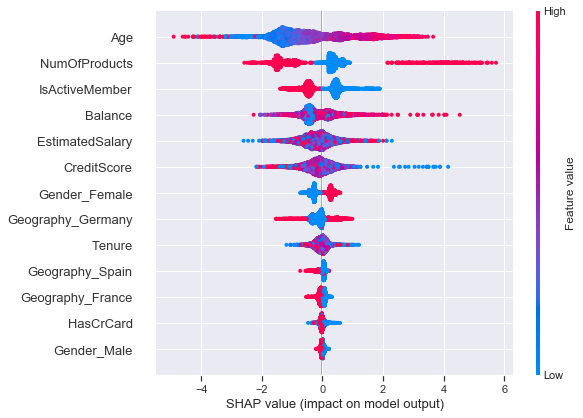

In [244]:
# Shap summary
shap.summary_plot(shap_values, X_train)

How to head the plot:
- Each dot in the plot is an instance (data point)
- On the left, features are shown from the most important (top) to the less important (bottom)
- The color on each data point is related to the original value of the feature (red: high values and blue: low values)
- The horizontal position of the data point in the plot indicates if the feature has a high impact in the prediction (Shap value)

For example:
- Being a female has clearly an higher impact in the prediction (Gender_Female = 1) than when Gender_Female = 0
- Having a high number of products (NumOfProducts) can have both a negative or very positive impact on the prediction

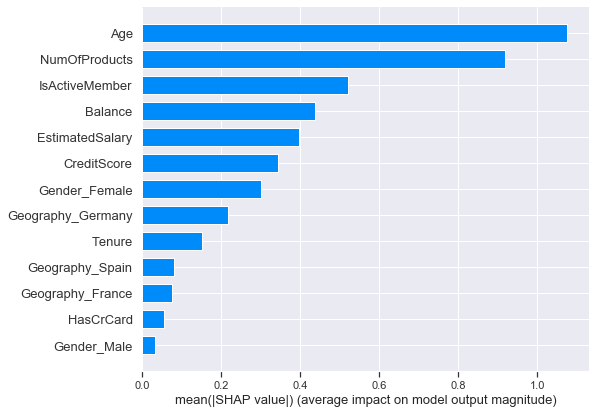

In [245]:
# Mean importance
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [246]:
# Visualizing some of instances - let's see the first 500
# Interact with menu to explore the results
shap.force_plot(explainer.expected_value, shap_values[:500,:], X_train.iloc[:500,:])

In [247]:
# Visualizing one instance only (first customer - index 0)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

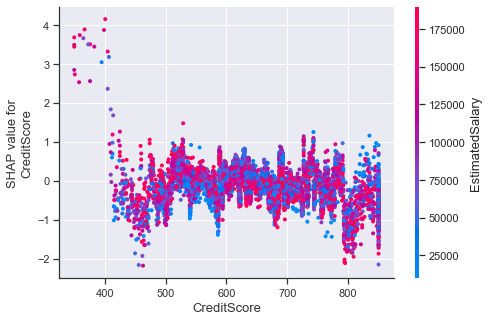

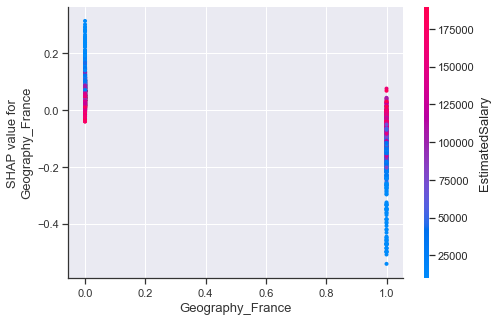

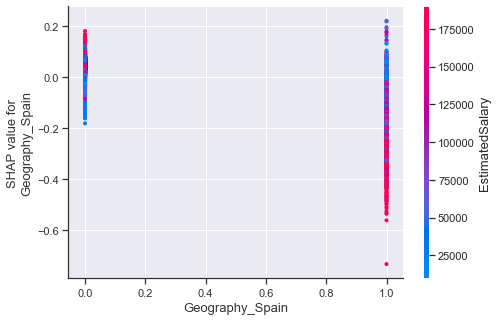

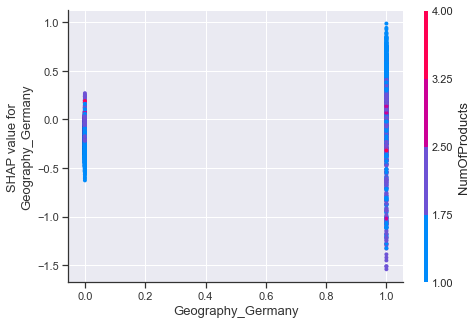

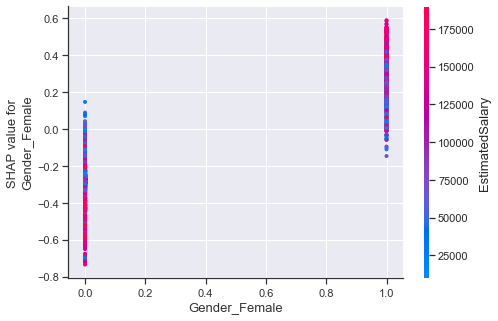

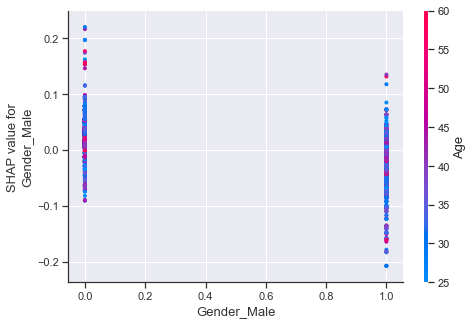

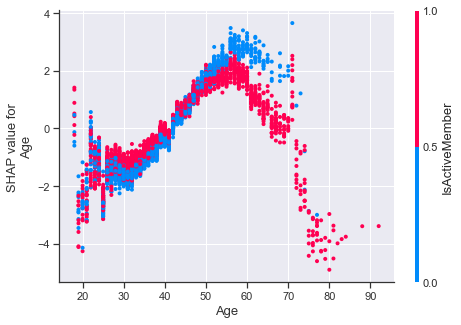

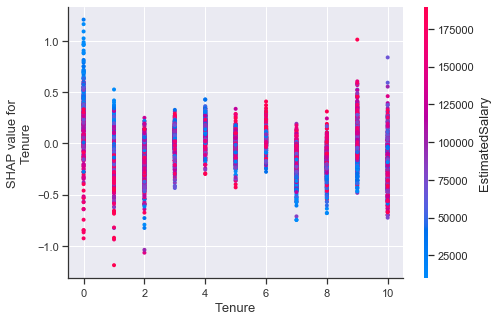

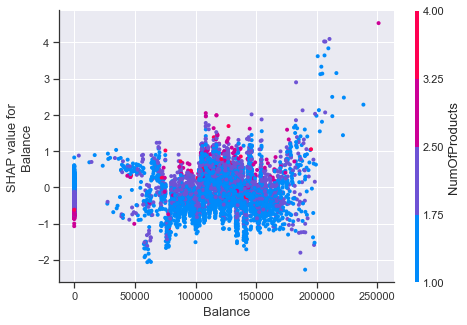

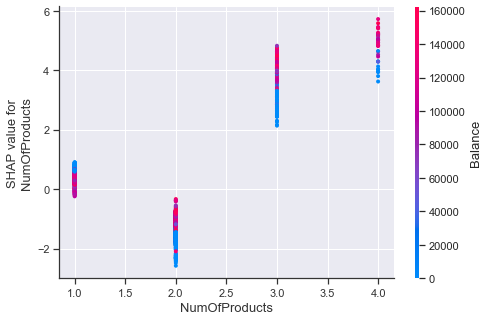

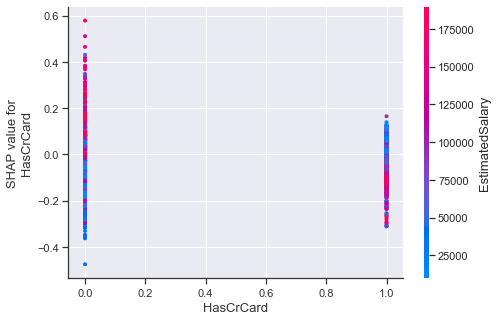

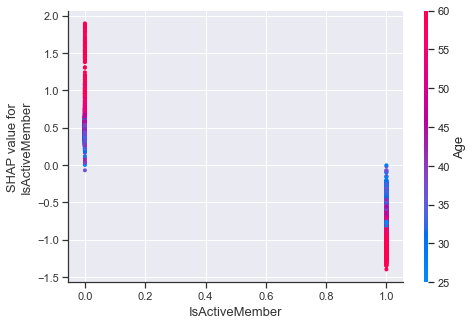

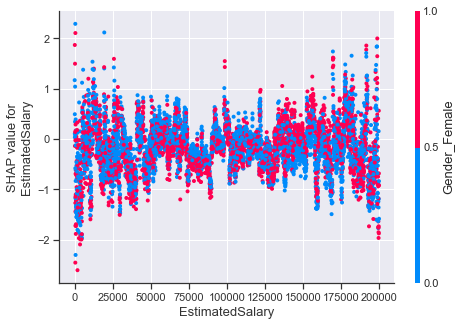

In [248]:
# Check the dependence between the different features
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_train, display_features=X_train)

If an interaction effect is present between the features it will show up as a distinct vertical pattern of coloring (see for example Age and IsActiveMember - there is an interaction effect between the two features)